
---------------------------------------

In this instalment, we cover vintage time series prediction methods introduced at the dawn of modern statistics era, i.e. in the 1950s by - among other - Brown, Holt and Winters. Their ideas were variations around the topic of exponential smoothing: weighted averages of past observations, with the weights decaying exponentially as the observations get older. A huge practical advantage of those methods that one only needs the previous smoothed value and current time series value to create a forecast for the next step - an important aspect in an era when a computer had less memory than a cheapest smartphone available in the market today.

As computing power became more available, exponential smoothing methods started fading into the "historical" section of statistics guide - until people started realizing that with the latency requirements of trading or e-commerce, speed is more important that additional 5pct improvement in error and one-step forecasts started making a comeback. 

Below, I present the most popular exponential smoothing methods - along with some practical tips and suggestions.

* [Exponential smoothing ](#section-one)
* [Popular methods](#section-two)
* [Anomaly detection](#section-three)
* [Example pipeline](#section-four)

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
import warnings
from data_sources import *

In [2]:
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category= FutureWarning)

In [3]:
# general settings
class CFG:
    data_folder = data
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

<a id="section-one"></a>
# Exponential smoothing 

As mentioned above, exponential moving average (EMA) assigns exponentially decreasing weights over time. The functions as a low-pass filter that removes high-frequency noise (and can be formulated as a special case of a more general problem of recursive filtering). Exponential smoothing models discussed in this module can be formulated as a special case of a general framework of state space models - those are discussed in part 4 of this series (there will be a link to the notebook once I've written it ;-)

A complete taxonomy of ETS (error, trend, seasonality) models can be found in Hyndman et al "Forecasting with Exponential Smoothing: The State Space Approach" - below we discuss the three most popular models from that class. 

<a id="section-two"></a>
# Popular methods

## EWMA

Simple Exponential Smoothing (Brown method) is defined by the relationship:

\begin{equation}
S_t = \alpha X_t + (1-\alpha) S_{t-1} \quad \text{where} \quad \alpha \in (0,1)
\end{equation}

or equivalently:

\begin{equation}
S_t = S_{t-1} + \alpha  (X_t - S_{t-1})
\end{equation}

Few observations around that definition:
* the smoothed series is a simple weighted average of the past and the present 
* interpretation of smoothing factor $\alpha$: recency vs smoothing (see below). It defines how quickly we will "forget" the last available true observation.
* $\alpha$ is selected on the basis of expert judgement or estimated (with MSE); statsmodels does the estimation by default
* by its very nature, smoothing needs some time to catch up with the dynamics of your time series. A rule of thumb for a reasonable sample size is that you need $\frac{3}{\alpha}$ observations.
* Exponentiality is hidden in the recursiveness of the function -- we multiply by  $(1−\alpha)$  each time, which already contains a multiplication by the same factor of previous model values.
* the method is suitable for forecasting data with no clear trend or seasonal pattern

With the setup of the above equation, we have the following form of a long term forecast:
\begin{equation}
\hat{X}_{t+h} = S_t
\end{equation}

which means simply that out of sample, our forecast is equal to the most recent value of the smoothed series.

It's an old cliche that a picture is worth a thousand words - so the three pictures below should give you a truly excellent intuition ;-) on how single exponential smoothing works. 



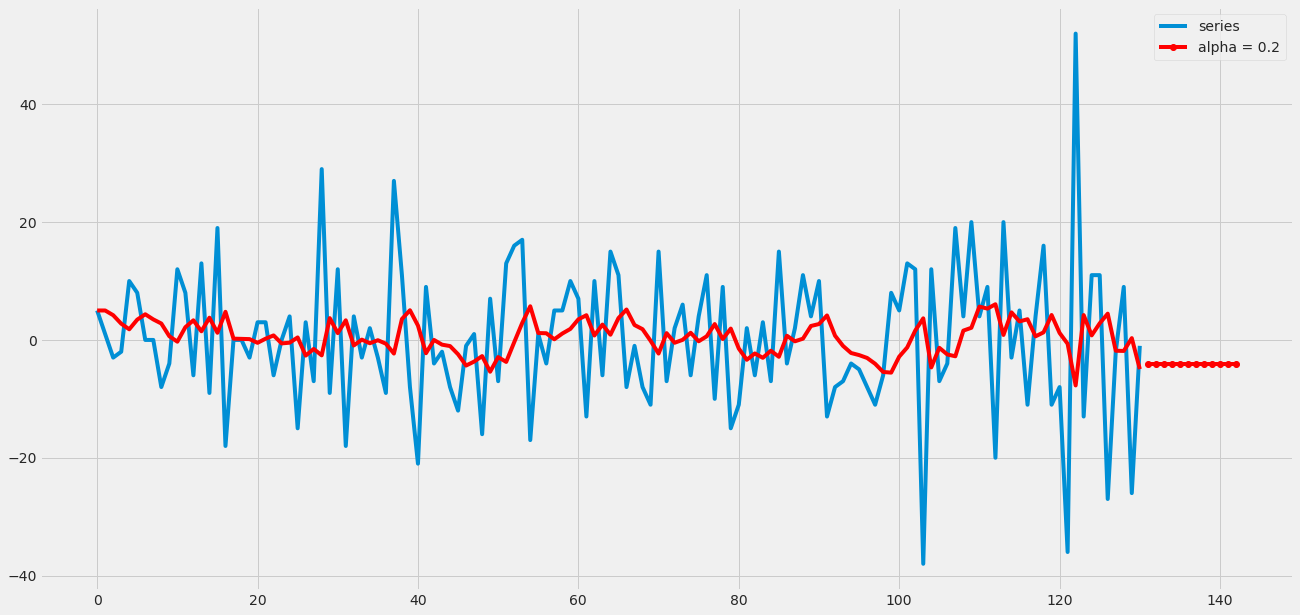

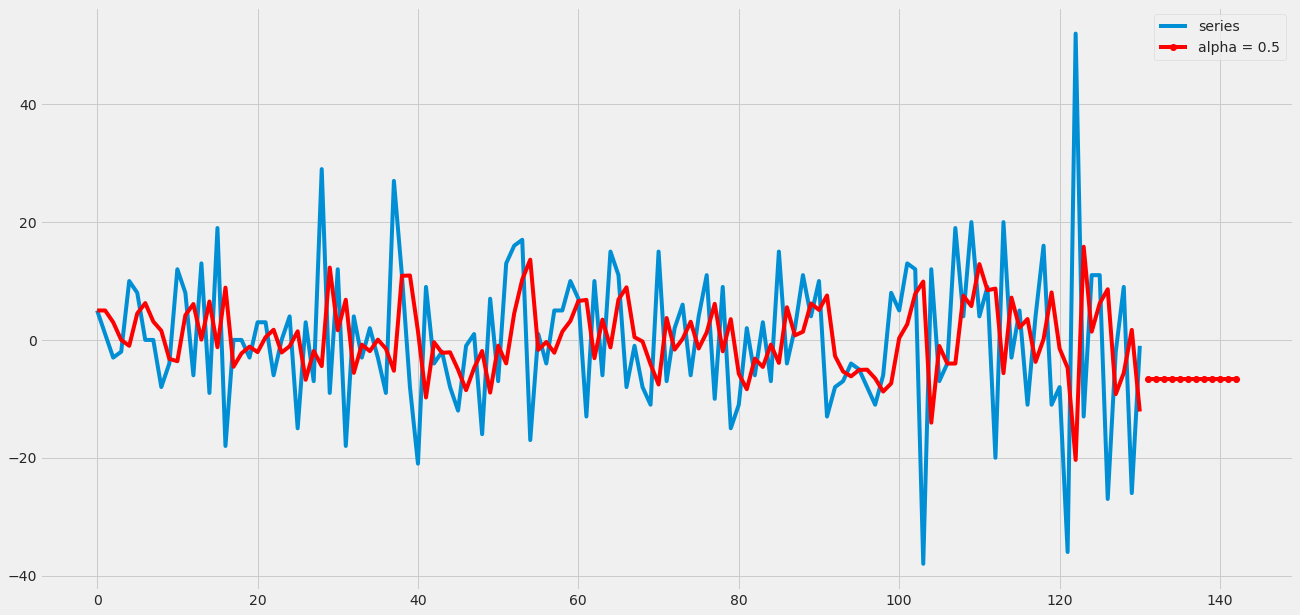

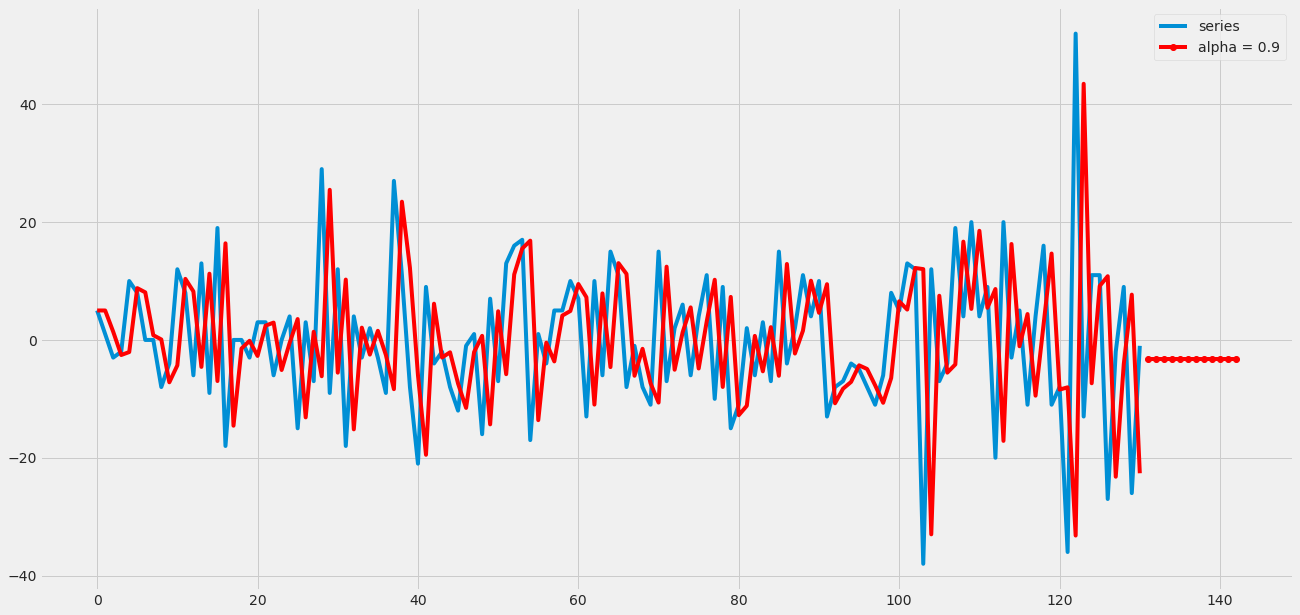

In [4]:
for alpha_sm in [0.2 , 0.5, 0.9]:
    df = pd.read_csv(exp1, header = None); df.columns = ['series']
    df.plot.line()
    fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

As you can see from the graphs above, the for small values of the smoothing constant $\alpha$ most of the variation has been removed and we have a series following just the general trend; on the other hand, high value of the $\alpha$ parameter results in hardly any smoothing at all and the new series follows the original very closely (albeit with a delay, which is obvious given the relationship between raw and smoothed values).


**Pro tip**: anytime you are using exponential smoothing that you did not write yourself, double-check the parametrization - does small $\alpha$ mean heavy smoothing or hardly any at all? The idea that the coefficient closer to 1 means less smoothing is merely a convention.


What happens if we apply the method to the passengers dataset, first introduced in [part 1](https://www.kaggle.com/konradb/practical-time-series-part-1-the-basics) ?

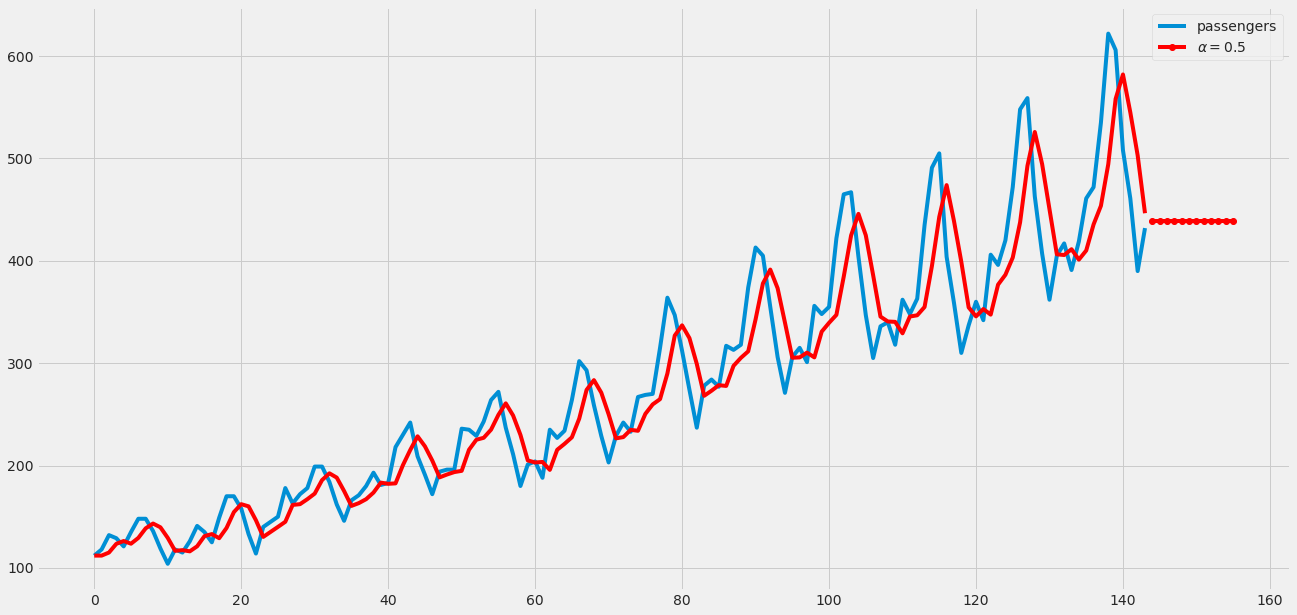

In [5]:
alpha = 0.5

df = pd.read_csv(passengers, usecols = ['passengers'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

On the one hand, the model does exactly what we expect it to do: beyond the range of the original data, it propagates the most recent smoothed value. On the other hand - it is not, to put it mildly, realistic to expect the number of passengers to flatline and the trend to disappear.

## Double Exponential Smoothing

Moving towards double exponential smoothing is akin to taking one more component in the seasonal decomposition: we began with level only, and we take into account the trend as well. We have learnt to predict intercept with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes.  Double exponential smoothing, a.k.a. the Holt method is defined by the relationship:

\begin{equation}
S_t = \alpha X_t + (1 - \alpha) (S_{t-1} + b_{t-1})\\
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1}
\end{equation}

where $S_1 = X_1$, $\quad b_1 = X_1 - X_0$ and $\alpha, \beta \in (0,1)$

The first equation describes the intercept, which depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. Complete prediction is composed of the sum of level and trend and the difference with simple exponential smoothing is that we need a second parameter to smooth the trend - as before, those can be set based on expert judgement or estimated (jointly) from the data. 

The forecast $h$ steps ahead is defined by
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t
\end{equation}

The forecast function is no longer flat but trending: $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value.

Let's compare the performance of the two methods on the passenger dataset:

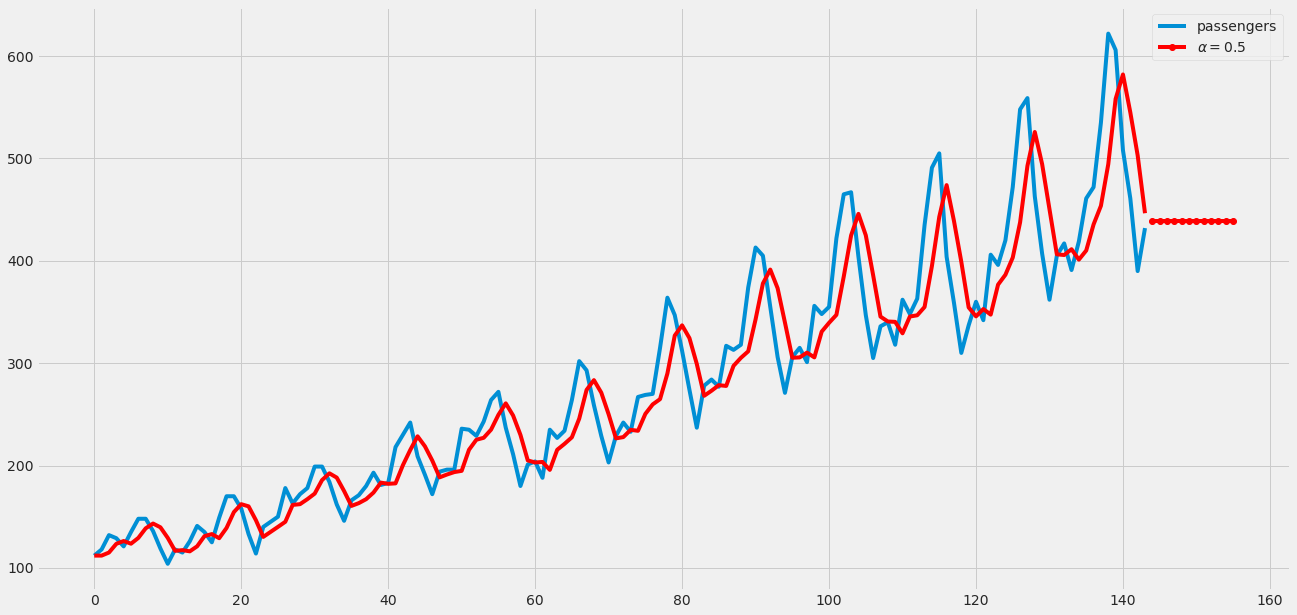

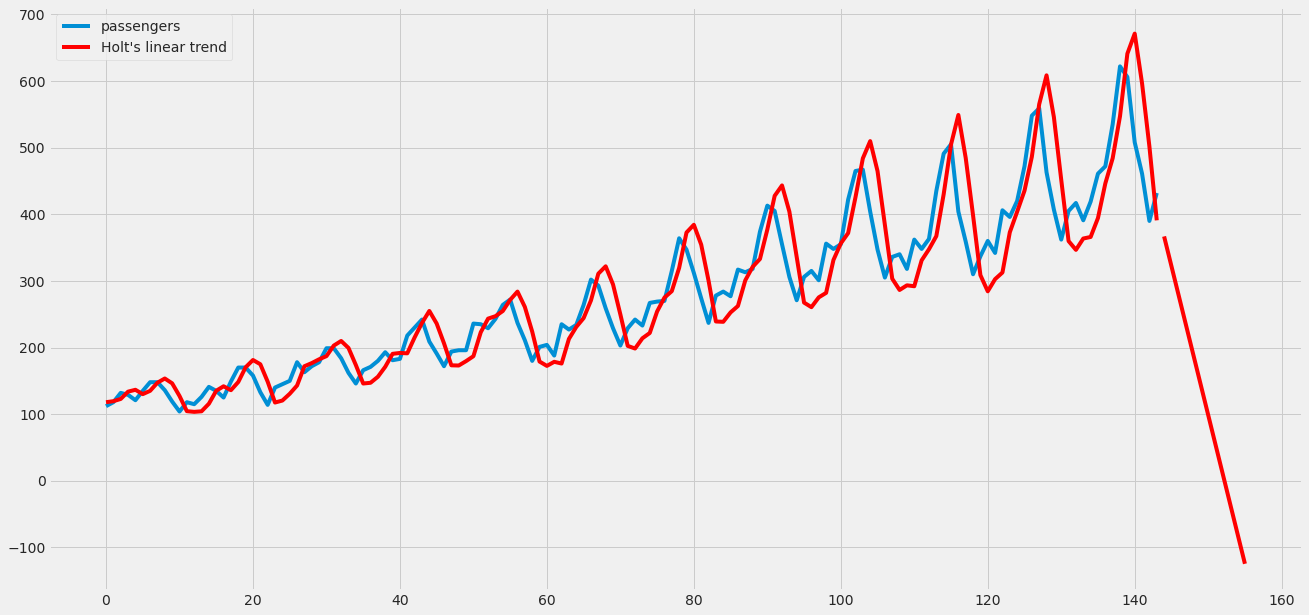

In [6]:
alpha = 0.5
df = pd.read_csv(passengers, usecols = ['passengers'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

df.plot.line()
fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)
plt.show()

It seems like we are moving in the right direction - the forecast going forward is not constant, but follows a trend. However, it is simply an extrapolation of the most recent (smoothed) trend in the data which means we can expect the forecast to turn negative shortly. This is suspicious in general, and clearly renders the forecast unusable in the domain context. 

## Triple Exponential Smoothing

If it worked once, maybe it can work twice? A natural extension is to introduce a smoothed seasonal component: triple exponential smoothing, a.k.a. Holt-Winters, is defined by:

\begin{equation}
S_t = \alpha (X_t - c_{t - L}) + (1 - \alpha) (S_{t-1} + b_{t-1}) \\
\end{equation}

\begin{equation}
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1} \\
\end{equation}

\begin{equation}
c_t = \gamma (X_t - S_{t-1} - b_{t-1})+ (1 - \gamma) c_{t-L}
\end{equation}

with $\alpha, \beta, \gamma \in (0,1)$.

The most important addition is the seasonal component to explain repeated variations around intercept and trend, and it will be specified by the period. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week. An obvious, yet worth repeating caveat: it makes sense to estimate seasonality with period $L$ only if your sample size is bigger than $2L$. 

The forecast $h$ steps ahead is defined by
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t + c_{(t-L + h) \;\; mod \;\;  L }
\end{equation}



ValueError: use_boxcox was set at model initialization and cannot be changed

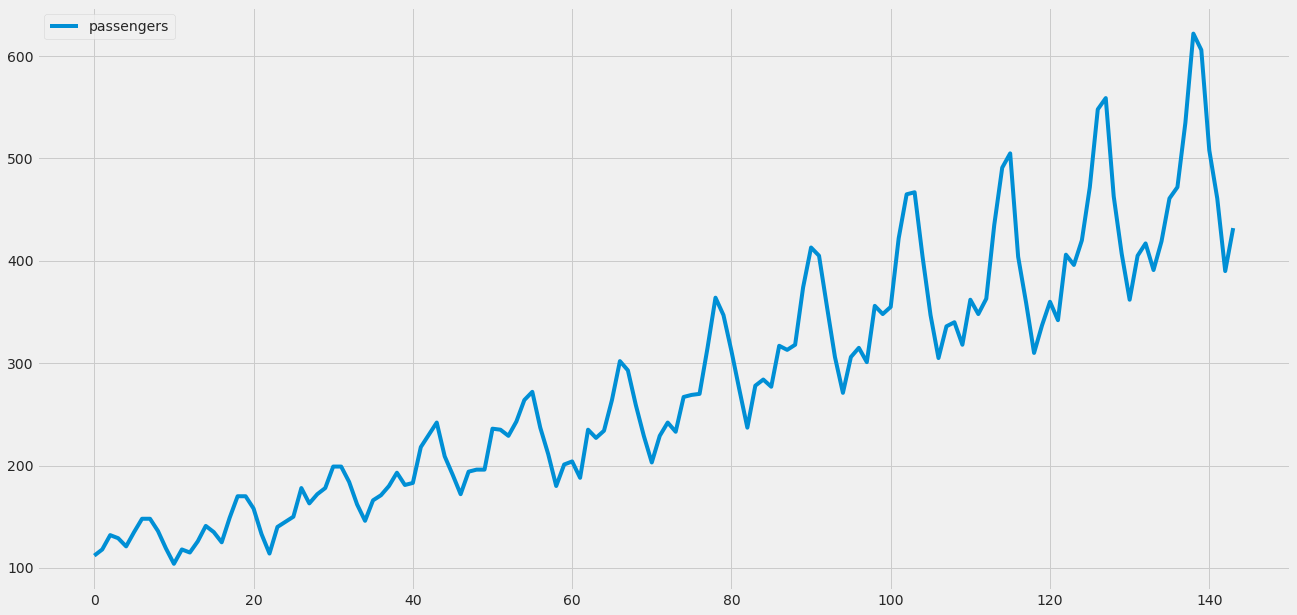

In [7]:
alpha = 0.5
df = pd.read_csv(passengers, usecols = ['passengers'])
df.plot.line()
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')
fit1 = fit1.fit(smoothing_level=0.5, use_boxcox=True)
fit1.fittedvalues.plot(color='red')
fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)
plt.ylim(0, 800)
plt.show()

Clearly, incorporating both the trend and seasonality explicitly leads to a much higher quality forecast.

## Taxonomy


We conclude that part by discussing briefly the taxonomy of smoothing models following "Forecasting: Principles and Practice"
by Hyndman and Athanasopoulos, chapter 7 (where the table below is taken from): the ones discussed above are the most popular ones, but not the only ones possible. By considering variations in the combinations of the trend and seasonal components, nine exponential smoothing methods are possible: each method is labelled by a pair of letters (T,S) defining the type of ‘Trend’ and ‘Seasonal’ components. For example, (A,M) is the method with an additive trend and multiplicative seasonality; (Ad ,N) is the method with damped trend and no seasonality; and so on.

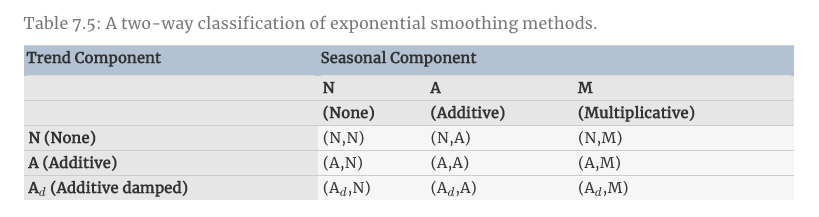

Some of these methods we have already seen using other names:
* (N,N) is simple exponential smoothing
* (A,N) is Holt's linear trend method
* (A,A) corresponds to additive Holt-Winters method

If you have some time on your hands, implementing some other methods might be a good exercise - but the word "practical" is there for a reason in the title, so we focus on using tools available out of the box - and understanding what we're doing.

<a id="section-three"></a>
# Anomaly detection

Anomaly detection is a process for identifying unexpected data, event or behavior that require some examination. It is a well-established field within data science and there is a large number of algorithms to detect anomalies in a dataset depending on data type and business context. One of the simplest, yet surprisingly effective ones, is a Z-score. The basic idea is that after suitable normalization, most kinds of data starts behaving like a Gaussian distribution (look up Central Limit Theorem if you would like to understand why) - which implies we only need mean and standard deviation to assess if a given observation is an outlier. Keep in mind that this approach is not 100pct foolproof: there are practical situations when CLT does not work (there's a reason it has a list of assumptions :-) and the Z score will not be meaningful in such circumstances; it does not happen very often, but it is not impossible.


The calculation of the Z-score for each individual point in the series proceeds in the following manner:
* select a window size $w$
* calculate rolling mean / standard deviation with window $w$
* demean and normalize by sd:
\begin{equation}
Z_t = \left|\frac{X_t - \bar{X}_m}{\sigma_m} \right|
\end{equation}

* Z-score measures number of sd away from mean $\implies$ values above 3 indicate extremely unlikely realization

In [ ]:
series = pd.read_csv(ambient_temperature_system_failure)  # load
series['timestamp'] = pd.to_datetime(series['timestamp'])
series['value'].plot()  # plot

In [ ]:
# pick a window size 
window_size = 25

# calculate rolling mean and standard deviation
xroll = series['value'].rolling(window_size)
series['mean_roll'] = xroll.mean()
series['sd_roll'] = xroll.std()

# calculate the Z-score
series['zscore'] = np.abs( (series['value'] - series['mean_roll']) / series['sd_roll'])
series['zscore'].plot()

In [ ]:
# check which observations are out of range
series.loc[series['zscore'] > 3][['timestamp', 'value']]

# Putting it all together

Now that we have all the pieces prepared, we can combine them to build a predictive model. We will use the dataset on daily US energy consumption (in billion kWh)

In [ ]:
df = pd.read_csv(us_energy)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()

Let's start with a seasonal decomposition (introduced in [part 1](https://www.kaggle.com/konradb/practical-time-series-part-1-the-basics)) to get a basic understanding of the dynamics:

In [ ]:
# perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df,period =12) 
figure = decomposition.plot()
plt.show()

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df["value"],period =12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

Comparison of the two graphs above shows a few things:
* there is definitely a trend in the data
* we have a clear seasonal pattern
* more stable behavior of the residuals in the second case suggests that a multiplicative decomposition is more appropriate.

Next step: we split the data into training and validation. Our cutoff point will be 2005:

In [ ]:
cutoff_date = '2005-12-31'
xtrain, xvalid  = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

We can fit hte model now:

In [ ]:
fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods=12, trend='mul', seasonal='mul')
fit1 = fit1.fit(use_boxcox=True)

Examining the parameters is fairly straightforward - as you can see, we did not specify the values of the smoothing constants, so they were automatically estimated.

In [ ]:
fit1.params_formatted

In [ ]:
# What do the residuals look like?
prediction = fit1.forecast(len(xvalid)).copy()
xresiduals = xvalid['value'] - prediction
plot_acf(xresiduals, lags = 25)
print()

In [ ]:
plot_pacf(xresiduals, lags = 25)
print()

The behavior of ACF / PACF (statistically significant autocorrelations) suggests that there is some first- and second-order dependence that our Holt-Winter model cannot capture.

In [ ]:
xvalid['prediction'] = prediction
xvalid.plot()

As you can see from the graph above, the model is doing a decent job for the first few years in the sample, but starts to overestimate the consumption afterwards - indicating perhaps a change in the nature of the trend (which would be consistent with the ACF pattern above). This confirms the intuition that there are aspects of the data generating process that are not adequately captured by our three prameter model - but for something that simple, you can make a solid case it is acceptable. 
